In [2]:
# Saving and type checking
import shutil
import typing
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from mpi4py import MPI
import numpy as np

# Operators
import ufl
from ufl import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from ufl import FacetNormal, SpatialCoordinate, variable
from ufl import diff as D
from ufl import nabla_div, nabla_grad, grad, div
from ufl import as_matrix as matrix
from ufl import lhs, rhs, split
from ufl import exp, sym, tr, sqrt, ln, sin, cos
# Graphics
import matplotlib.pyplot as plt
# Logging
from tqdm import tqdm

from local_fenics.fenics import *

In [3]:
N=10
domain = mesh.create_unit_square(
    nx=N,
    ny=N,
    comm=MPI.COMM_WORLD,
    cell_type=mesh.CellType.triangle,
    )
# domain = mesh.create_unit_square(
#     points=((-0.5, -0.5), (1.5, 1.5)),
#     n=(N, N),
#     comm=MPI.COMM_WORLD,
#     cell_type=mesh.CellType.triangle
#     )

el = ufl.FiniteElement(family='CG', cell=domain.ufl_cell(), degree=1)
Mix_el = el * el
W = FunctionSpace(mesh=domain, element=Mix_el)
W0, _ = W.sub(0).collapse()
W1, _ = W.sub(1).collapse()

x, y = SpatialCoordinate(W)
dx = ufl.Measure('cell', subdomain_id='everywhere')
u, v = TestFunctions(W)
s, s0 = Function(W), Function(W)

cN, cP = split(s)
cN0, cP0 = split(s0)

cNS = s.sub(0)
cPS = s.sub(1)
cNS.name = 'C neutral'
cPS.name = 'C polimer'


save_dir = '/home/VTK/System_files'
num_save = 1

In [4]:
n_steps = 100

# dt = 0.001
# T = n_steps * dt
# OR
T = 3
dt = T / n_steps

n_shecks = 10
check_every = int(n_steps / n_shecks)

s.sub(0).interpolate(lambda x: 0.2 + x[0] - x[0])
s.sub(1).interpolate(lambda x: 0.001 + x[0] - x[0])
s.x.scatter_forward()

p1 = 0.13
a = 0.1
e = a * exp(-cP / p1)
b = a * exp(-cP / p1)
g = 4

light_f = lambda x: np.where(
    npand(
        npand(x[0] < 0.7, x[0] > 0.3),
        npand(x[1] < 0.7, x[1] > 0.3),
        ),
    1,
    0,
    )
# light_f = lambda x: np.where(
#     npand(x[0]<0.5,x[1]<0.5
#         ),
#     1,
#     0,
#     )


In [5]:
# create_connectivity(domain=domain)
# x0,x1,y0,y1 = 1,2,3,4
# markers=[
#     [x0,lambda]
# ]
# bcs = [
#     DirichletBC(space=(W.sub(0),))
# ]

In [6]:
light = Function(W1, light_f)
light.name = 'Light'

f = g * (1-cP-cN) * (-ln((1-cP-cN) / (1-cN)))**((g-1) / g)

F1 = (1/dt) * (cN-cN0) * u * dx
F1 += a * (grad(cN)|dot|grad(u)) * dx
F1 += -a * cP * (grad(cN)|dot|grad(u)) * dx
F1 += a * cN * (grad(cP)|dot|grad(u)) * dx
F1 += e * cP * (grad(cN)|dot|grad(u)) * dx
F1 += -e * cN * (grad(cP)|dot|grad(u)) * dx
F1 += (e/p1) * cP * (grad(cP)|dot|grad(cN)) * u * dx
F1 += -(e / p1) * cN * (grad(cP)|dot|grad(cP)) * u * dx

F2 = (1/dt) * (cP-cP0) * v * dx
F2 += b * (grad(cP)|dot|grad(v)) * dx
F2 += b * cP * (grad(cN)|dot|grad(v)) * dx
F2 += -b * cN * (grad(cP)|dot|grad(v)) * dx
F2 += -e * cP * (grad(cN)|dot|grad(v)) * dx
F2 += e * cN * (grad(cP)|dot|grad(v)) * dx
F2 += (b/p1) * cP * (grad(cP)|dot|grad(cN)) * v * dx
F2 += -(b / p1) * cN * (grad(cP)|dot|grad(cP)) * v * dx
F2 += -(e / p1) * cP * (grad(cN)|dot|grad(cP)) * v * dx
F2 += (e/p1) * cN * (grad(cP)|dot|grad(cP)) * v * dx
F2 += (b/p1) * (grad(cP)|dot|grad(cP)) * v * dx
F2 += -light * f * v * dx

F = F1 + F2

In [7]:
problem = NonlinearProblem(
    F=F,
    bcs=[],
    u=s,
    petsc_options={
        'ksp_type': 'cg',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'superlu_dist',
        }
    )

In [8]:
try:
    shutil.rmtree(save_dir)
except:
    print('Directory empty yet')
with io.XDMFFile(
    domain.comm, save_dir + f'/System{num_save}.xdmf', 'w'
    ) as file:
    file.write_mesh(domain)

    time = 0
    file.write_function(cNS, 0)
    file.write_function(cPS, 0)
    file.write_function(light, 0)
    s0.interpolate(s)

    for step in tqdm(
        desc='Solving PDE', iterable=np.arange(0, n_steps, dtype=int)
        ):
        s = problem.solve()
        s0.interpolate(s)
        # light.interpolate()
        if step % check_every == 0:
            file.write_function(cNS, time + dt)
            file.write_function(cPS, time + dt)
            file.write_function(light, time + dt)
        time += dt

Solving PDE: 100%|██████████| 100/100 [00:01<00:00, 57.94it/s]


(FDM1) CFL: 0.3
Norm of polimer: 2.01
Norm of neutral: 2.83


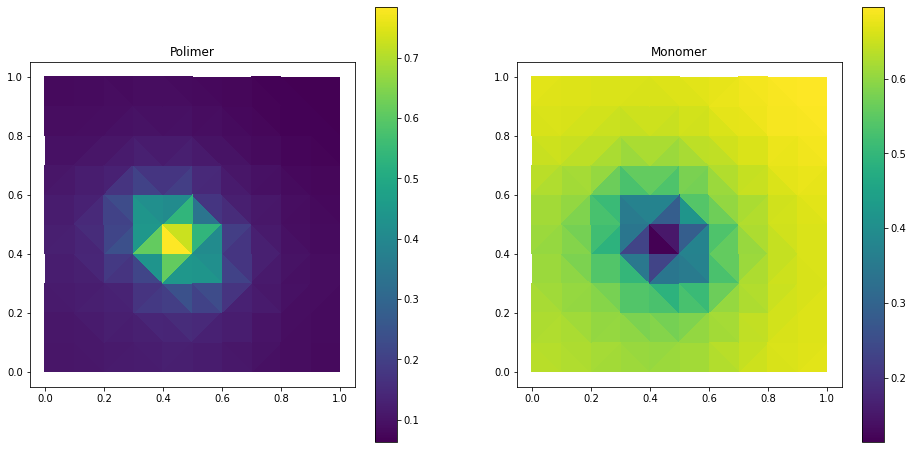

In [9]:
light_col = Function(W0, light)
cNS_col = Function(W0, cNS)
cPS_col = Function(W0, cPS)
cMS_col = Function(W0, 1 - cNS_col - cPS_col)

print(f'(FDM1) CFL: {a*N**2*dt}')
print(f"Norm of polimer: {cPS_col.x.norm():.2f}")
print(f"Norm of neutral: {cNS_col.x.norm():.2f}")
fig, (ax, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
PostProcess.graph2D(
    fig=fig,
    natural_show=True,
     # points_on=True,
    lists=[
        [cPS_col, ax, 'Polimer'],
        [cMS_col, ax2, 'Monomer'],
        ],
    )